In [1]:
##Load data
import os
import csv

samples = []
with open('./data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    next(reader, None)
    for line in reader:
        samples.append(line)

from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

import cv2
import numpy as np
import sklearn
from sklearn.utils import shuffle

def generator(samples, batch_size=64):
    num_samples = len(samples)
    angle_offset = 0.32
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                angle = float(batch_sample[3])
                for i in range(3):
                    name = './data/IMG/'+batch_sample[i].split('/')[-1]
                    image = cv2.imread(name)                    
                    images.append(image)
                    angle = float(batch_sample[3])+(i==1)*angle_offset+(i==2)*-angle_offset
                    angles.append(angle)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield shuffle(X_train, y_train)

# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

In [2]:
##Model Pipeline
from keras.models import Sequential
from keras.layers import Flatten,Dense,Lambda,Cropping2D
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

model = Sequential()
model.add(Lambda(lambda x: x/255.0-0.5,input_shape = (160,320,3)))
model.add(Cropping2D(cropping=((60,25),(0,0))))
model.add(Convolution2D(24,5,5,subsample=(2,2),activation='relu'))
model.add(Convolution2D(36,5,5,subsample=(2,2),activation='relu'))
model.add(Convolution2D(48,5,5,subsample=(2,2),activation='relu'))
model.add(Convolution2D(64,3,3,activation='relu'))
model.add(Convolution2D(64,3,3,activation='relu'))
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

model.compile(loss = 'mse',optimizer = 'adam')

Using TensorFlow backend.


Epoch 1/5
15552/15564 [============================>.] - ETA: 0s - loss: 0.0443

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


15648/15564 [==============================] - 39s - loss: 0.0442 - val_loss: 0.0338
Epoch 2/5
15570/15564 [==============================] - 37s - loss: 0.0345 - val_loss: 0.0318
Epoch 3/5
15570/15564 [==============================] - 37s - loss: 0.0293 - val_loss: 0.0316
Epoch 4/5
15648/15564 [==============================] - 37s - loss: 0.0262 - val_loss: 0.0250
Epoch 5/5
15570/15564 [==============================] - 37s - loss: 0.0230 - val_loss: 0.0245
model saved.
dict_keys(['val_loss', 'loss'])


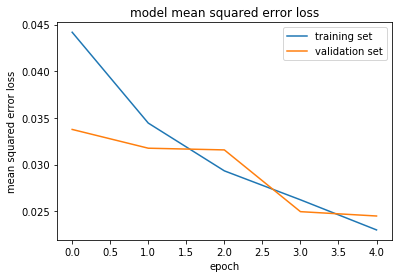

In [3]:
##Model training & visualization
from keras.models import Model
import matplotlib.pyplot as plt

history_object = model.fit_generator(train_generator, samples_per_epoch= len(train_samples)*2, validation_data=validation_generator,nb_val_samples=len(validation_samples)*2, nb_epoch=5)

model.save('model.h5')
print('model saved.')

### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()